In [1]:
import numpy as np
from numpy.random import randint,uniform,choice
import matplotlib.pyplot as plt
import datetime
import time
from scipy.integrate import odeint

from numba import jit,njit,vectorize

In [2]:
import numpy as np
from numpy.random import randint,uniform,choice

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________

n_pop = 10000    # Total population
n_loc = 2750     # Total number of locations
n_net = 250      # Total number of networks
n_overlap = 251  # Include the possibility of overlap between work and home locations
n_hospitals = 10 # Set the number of hospitals.

n_asym = 10      # Initial number of asymptomatics

# Initial populations ###########

n0 = np.array([n_pop-n_asym, n_asym, 0, 0, 0],dtype=np.int64)
           # [S,            A,      I, R, H ]

##################################


labels      = np.array([0,1,2,3,4],dtype=np.int64) # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)
person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 6              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    
rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.45  # S -> A
rate_array[1][2] = 0.205 # A -> I
rate_array[1][3] = 0.136 # A -> R
rate_array[2][3] = 0.1   # I -> R
rate_array[2][4] = 0.25  # I -> H
rate_array[4][3] = 0.1   # H -> R


Cpars = np.array([0,  1,  1,  0,  0.1,  0.1],dtype=np.float64)  # Transmissivity of different individuals. Asymptomatic and symptomatics 
                                     # are just as infectious, hospitalised and quarantined are 10 times less infectious
       # Contact parameters


total_loc_confined_time = 0

days_bw_hq_tests = 1
days_bw_lq_tests = 1

In [3]:
## CREATE POPULATION #####

def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks
# counter = 1
# home = n_overlap-1 
for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)              # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)
#     print(home)
#     if(counter%4==0):
#         home += 1
#     counter += 1
    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 1                             # This number must be between 0 and 1 (probability of shifting along link)

        
r = choice(n_pop,size=n_asym,replace=False)        # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

In [4]:
@vectorize
def setval(l,m):
    return np.int64(m)

@vectorize
def randdate(l):
    return randint(np.int64(l))

@njit
def rnd(x, decimals, out):
    return np.round_(x, decimals, out)

@njit
def log_output(lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved):
    
    print("# LQ Tests Done in total  : "+str(lq_tests_conducted))
    print("# HQ Tests Done in total  : "+str(hq_tests_conducted))
    print("# ALL Tests Done in total : "+str(tests_conducted))
    print("# Results Given in total  : "+str(results_declared))
    print("# Locations Moved in total: "+str(locations_moved))

@njit
def TLR(rate, Tpars, T, home_loc_state, quarantine_confined, test_frac,dt):
    
    pop = np.copy(quenched_pop)
    n_per_location = np.copy(quenched_n_per_location)
    link_weight = np.copy(quenched_link_weight)
    n = np.copy(n0)
    
    is_confined = np.zeros(n_pop,np.bool_)               # Boolean array, is confined? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,np.bool_)               # Boolean array, is being tested?
    loc_confined= np.zeros(n_loc,np.bool_)               # Boolean array, is the location confined? <---NEW

    test = Tpars
    test_result = np.zeros(n_pop,dtype=np.int64)                # Array to hold results of test (+1 positive, -1 negative)

    loc_confined_time = setval(np.zeros(n_loc), -1000)
    next_test_date = setval(np.zeros(n_pop), 7)                # Don't conduct a test before this date per person. (Initially all day 0)    
    result_declared_date = setval(np.zeros(n_pop),-1000)       # Declare the result of last test on this day (initiall -1000)    
    
    
    tests_conducted    = 0
    hq_tests_conducted = 0
    lq_tests_conducted = 0
    results_declared   = 0
    locations_moved    = 0
    
    t = 0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],              # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],              # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],              # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],np.float64)  # the change in that particular state, given an event.

    
    transitions = np.zeros((n_states,n_states),np.int64)
    r = np.zeros(n_events,np.float64)                          # Empty array to store rates per event
    K = np.zeros(n_events,np.float64)               # Empty array to store number of events that occur in dt (Poisson distributed)
    
    alpha = 1 - Cpars[5]   # Effective reduction in transmissivity of infected individuals (BOTH A and I)
    
    
#     #### TESTS #################################
    
    tests_available_daily =np.int64(test_frac/100 * n_pop)
    tests_available_now   =np.int64(test_frac/100 * n_pop)  # test_frac% of population number of tests available
    
    lq_tests_daily      =np.int64(test[0][3] * tests_available_daily)
    lq_tests_available  =np.int64(test[0][3] * tests_available_daily)
    
    hq_tests_daily      =np.int64(test[1][3] * tests_available_daily)
    hq_tests_available  =np.int64(test[1][3] * tests_available_daily)
    
    if(lq_tests_daily + hq_tests_daily > tests_available_daily):
        print("More LQ + HQ tests available than total! Are you sure your test fractions for each test type are correct?")
    
    lq_sensitivity = test[0][0]
    lq_specificity = test[0][1]
    lq_result_delay= test[0][2]
    
    hq_sensitivity = test[1][0]
    hq_specificity = test[1][1]
    hq_result_delay= test[1][2]
    
#     ############################################
        
    output = np.zeros((np.int64(T+1),9),dtype=np.int64)
    
    output[0] = np.array([t,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
    
    day = np.int64(0)
    
    op_counter = np.int64(0)
    print(dt)
    while(t<T):
       
        for i in range(0, n_loc):                 # Loop over locations
            
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            N = len(indices)
            
            if(N==0):
                continue                           # If no one's in this location, skip this loop
            
            V = N - alpha*n_per_location[i][4]                                  # Assume one-to-one contact 
            
            conf_by_state_in_loc = np.zeros(n_states,np.int64) # Number of confined individuals by state in location
            
            if(quarantine_confined == True):       # If you want to reduce infectivity of confined individuals, find out how many there are
                conf_state = is_confined[indices]
                
                for m in range(0,N):               # Change the new "confined per state location" numbers
                    if(conf_state[m] == True):     # If the person is confined
                        conf_by_state_in_loc[pop[indices[m]][0]] += 1
                
            # This part can be done more efficiently using a matrix, but that's for later
            
            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha)  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            flag = False
            counter = 0
            
            while(flag == False):
                for j in range(0,n_events):
                    K[j] = np.random.poisson(r[j]*dt)
                    
                
                transitions[0][1] = K[0]
                transitions[1][2] = K[1]
                transitions[1][3] = K[2]
                transitions[2][3] = K[3]
                transitions[2][4] = K[4]
                transitions[4][3] = K[5]

                n_removed = np.sum(transitions,axis=1) # Number of people ideally needing to be removed

                for j in range(0,n_states):
                    if( n_per_location[i][j] < n_removed[j] and n_removed[j] != 0):
                        y=np.empty_like(transitions[j,:])
                        transitions[j,:] = rnd(transitions[j,:]/n_removed[j] * n_per_location[i][j],0,y)

                K[0] = transitions[0][1]
                K[1] = transitions[1][2]
                K[2] = transitions[1][3]
                K[3] = transitions[2][3]
                K[4] = transitions[2][4]
                K[5] = transitions[4][3]

                n_per_location[i] +=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))            # Change number per location by Sum_j v_ij K_j 
                
                
                if(np.any(n_per_location[i]<0)):
                    print("Negative populations! Shouldn't be happening!")
                    print(transitions)
                    print(n_per_location[i])
                    print("Rolling back")
                    n_per_location[i] -=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))
                    print(n_per_location[i])
                    print("Trying again...")
                    counter += 1
                    
                    if counter == 9:                        # Don't let more than 10 retries occur
                        print("Fatal error: 10 retries didn't get rid of negative populations")
                        break
                else:
                    flag = True
            

            if(np.all(transitions==0)):               # Skip this loop if no transitions need to occur
                continue
            
            
            done = np.zeros(len(indices),np.bool_)        # Array to make sure same individual isn't shifted more than once 
            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==3): # If they recover,
                                is_confined[indices[m]] = False # Remove any confinement, and
                                
                                # Shift them home
                                if( pop[indices[m]][3] != pop[indices[m]][1] or pop[indices[m]][3] != pop[indices[m]][2] ):
                                    
                                    n_per_location[pop[indices[m]][3]][k] -= 1
                                    pop[indices[m]][3] = pop[indices[m]][1]   # Send them home
                                    n_per_location[pop[indices[m]][3]][k] += 1
                                    
                            elif(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][k] -= 1 # Decrement the number of hospitalised in current (HOME or WORK) location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of hospitalised (4) in current (hospital) location
                                
                                is_confined[indices[m]] =  False # Remove confinement   
                            
                            done[m] = True            # Don't repeat this index
                            l += 1

        for i in range(0,n_pop): 
            
            #### TESTING ###########################################
            
            p = test_frac/100 * dt     # Probability of testing someone (random) in time dt
            
            if (day >= next_test_date[i] and not being_tested[i] 
                and uniform(0.0,1.0) < p and tests_available_now>0): # Check if person i should be tested
                
                # If so, perform a test.
                being_tested[i]   = True            
                tests_conducted += 1
                
                tests_available_now -= 1                     # Reduce number of tests available
                
                test_type = choice(np.array([0,1]))                    # Choose HQ or LQ test randomly                
               
                if(test_type == 0 and lq_tests_available<=0):   # If a LQ test is chosen but no LQ tests available
                    test_type = 1                               # Do a HQ test
                elif(test_type == 1 and hq_tests_available<=0): # Or if a HQ test is chosen but no HQ tests available
                    test_type = 0                               # Do a LQ test
                    
                    
                if(test_type == 0 and lq_tests_available>0):
                    
                    # Do low quality test    
                    lq_tests_conducted += 1
                    lq_tests_available -= 1  # Reduce number of LQ tests
                    
                    next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test
                    result_declared_date[i] = day + lq_result_delay # No. of days (from today) to wait to get the result
                
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                    
                elif(test_type == 1 and hq_tests_available>0):
                    
                    # Do high quality test
                    hq_tests_conducted += 1
                    hq_tests_available -= 1  # Reduce number of HQ tests
                    
                    next_test_date[i]       = day + days_bw_hq_tests  # Set date for next test
                    result_declared_date[i] = day + hq_result_delay   # No of days (from today) to wait to get the result
                    
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                        
            #### DONE TESTING ######################################
            
            #### DECLARING RESULTS #################################
            
            if (day == result_declared_date[i] and being_tested[i]):  # Should we declare the person's results?
                
                # If so, set them to not being_tested
                being_tested[i] = False
                results_declared += 1
                
                # Declare results
                
                if (test_result[i] == 1 and pop[i][0]!=4):             # If they tested positive AND are now not in a hospital
                    
                    is_confined[i] = True                              # Confine them 
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state           # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined

                elif(test_result[i] == -1 or pop[i][0] == 4):          # If the test result is negative OR if the person's moved to the hospital
                    
                    is_confined[i] = False                             # If result is negative, let them move about
        
                test_result[i] = 0                                     # Set test_result back to 0      
            
            #### DONE DECLARING RESULTS ############################
            
            #### MOVE PEOPLE AROUND ################################  
        
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined

                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                   # If they're in any other location, keep them there.
    
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
        
        
        if(t>day):
            day += 1
            output[day] = np.array([day,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
            tests_available_now = tests_available_daily
            lq_tests_available  = lq_tests_daily
            hq_tests_available  = hq_tests_daily
#             print(day)
        
        t += dt
        # while loop ends
    
    # Counting recovered Healthcare Workers    
    hcw_recovered = 0
    for i in range(0, n_pop):  
        if(pop[i][2]<n_hospitals and pop[i][0] == 3): # If a healthcare worker is recovered
            hcw_recovered += 1
    
    return output, test, np.array([home_loc_state,quarantine_confined,test_frac, lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved, hcw_recovered])

In [5]:
# IMPORT POPULATION #######################

quenched_pop            = np.copy(pop)
quenched_n_per_location = np.copy(n_per_location)
quenched_link_weight    = np.copy(link_weight)

###########################################

Tpars  = np.array([[0.6, 0.98, 0, 0],          # Low quality: sensitivity, specificity, result delay, Fraction of tests
                   [1.0, 1, 0, 1]])         # High quality: sentitivity, specificity, result delay, Fraction of tests

tf=100

In [6]:
%%time

rate = np.copy(rate_array)
mc_runs = 10

runs_0005=[]
runs_002=[]
runs_01=[]
runs_02=[]
runs_05=[]

runs = [runs_0005,runs_002,runs_01, runs_02, runs_05]

dts = [0.005,0.02,0.1,0.2,0.5]

res_0005=[]
res_002=[]
res_01=[]
res_02=[]
res_05=[]

res = [res_0005,res_002,res_01,res_02,res_05]

for i in range(0, len(dts)):
    for mc in range(0, mc_runs):
        op,test,details = TLR(rate, Tpars, tf, False, False, 0,dts[i])
    
        res[i].append(op)
        

0.005
0.005
0.005
0.005
0.005
0.005
0.005
0.005
0.005
0.005
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.2
0.2
0.2
0.2
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[10 -1  2  9  0]
Rolling back
[10  3  0  7  0]
Trying again...
0.2
0.2
0.2
0.2
0.2
0.2
0.5
0.5
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[10 -1  2  3  0]
Rolling back
[10  3  0  1  0]
Trying again...
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[18 -1  2  9  0]
Rolling back
[18  3  0  7  0]
Trying again...
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[ 7 -1  2 10  0]
Rolling back
[7 3 0 8 0]
Trying again...
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 2 2]
 [0 0 0 0 

ValueError: poisson(): lambda < 0

In [7]:
...stop
res_05_extra = []

SyntaxError: invalid syntax (<ipython-input-7-9f2a53135c6a>, line 1)

In [53]:


for i in range(0,5):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0,0.5)
    res_05_extra.append(op)

0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[10 -1  2  3  0]
Rolling back
[10  3  0  1  0]
Trying again...
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[14 -1  2  7  0]
Rolling back
[14  3  0  5  0]
Trying again...
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[15 -1  2  3  0]
Rolling back
[15  3  0  1  0]
Trying again...
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 2 2]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[ 0  0 -1  3  2]
Rolling back
[0 0 3 1 0]
Trying again...
0.5
Negative populations! Shouldn't be happening!
[[0 0 0 0 0]
 [0 0 2 2 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[14 -1  2  6  2]
Rolling back
[14  3  2  4  0]
Trying again...
0.5


In [74]:
print(len(res_05_extra))
print(len(res[-1]))
print(len(res_05))
# print(stds)

6
10
10


[58 69 65 62 56]
[8.0771282  9.62496753 8.61626369 6.80367548 4.4       ]


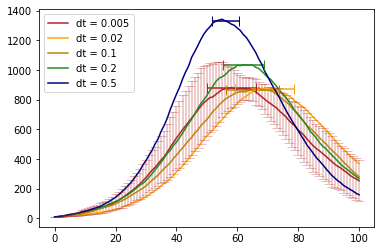

In [99]:
# %matplotlib notebook
averages = np.zeros((101,5),float)
stds     = np.zeros((101,5),float)
peak_stds= np.zeros(5,float)
peak_avgs= np.zeros(5,float)

for k in range(0,len(res)):     # For each dt
    for i in range(0,101):              # For each point
        temp = []
        for j in range(0,10): # For each run
            temp.append(res[k][j][:,2][i]+res[k][j][:,3][i]+res[k][j][:,5][i])
        
        averages[i][k] = np.average(temp)
        stds[i][k] = np.std(temp)

for i in range(0,len(res)):     # For each dt
    max_time = []
    for j in range(0,10):       # For each run
        
        temp_all_inf = res[i][j][:,2]+res[i][j][:,3]+res[i][j][:,5]
        mt = np.argmax(temp_all_inf)
        max_time.append(mt)
    
    peak_avgs[i] = np.mean(max_time)
    peak_stds[i] = np.std(max_time)
    
peak_avgs = np.int64(peak_avgs)
print(peak_avgs)
print(peak_stds)
clrs = ["firebrick", "orange","darkgoldenrod","forestgreen","navy"]
        
for i in range(0,len(res)):
    plt.plot(np.linspace(0,100,101),averages[:,i],label="dt = "+str(dts[i]),color=clrs[i])
    
plt.errorbar(np.linspace(0,100,101),averages[:,0],yerr=stds[:,0],ls='none',color=clrs[0],solid_capstyle='projecting', capsize=5,alpha=0.3)    

for i in range(0,len(res)):
    plt.errorbar(peak_avgs[i],averages[:,i][peak_avgs[i]],xerr=peak_stds[i],ls='none',color=clrs[i],solid_capstyle='projecting', capsize=5,alpha=1)    
# plt.yscale('log')
plt.legend()

In [101]:
for i in range(0,len(res)):     # For each dt
    for j in range(0,10):       # For each run
        np.savetxt("./Comparing_dt_"+str(dts[i])+"_run_"+str(j)+".txt",res[i][j],delimiter=" ",fmt="%i")

In [72]:
len(0)

TypeError: object of type 'int' has no len()

In [ ]:
average_runs_1 = np.zeros((121,9),float)

for i in range(0,len(runs)):
    average_runs_1 = average_runs_1 + runs_1[i]

average_runs_1 = average_runs_1/len(runs_1)

plt.plot(average_runs[:,0],average_runs[:,2]+average_runs[:,3]+average_runs[:,5])
plt.plot(average_runs_001[:,0],average_runs_001[:,2]+average_runs_001[:,3]+average_runs_001[:,5])
plt.plot(average_runs_1[:,0],average_runs_1[:,2]+average_runs_1[:,3]+average_runs_1[:,5])

plt.yscale('log')

In [ ]:
,,,

In [ ]:
%%time

rate = np.copy(rate_array)
mc_runs = 10

runs_001=[]


for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    runs_001.append(op)

In [ ]:
average_runs_001 = np.zeros((121,9),float)

std_runs_001 = np.zeros(121,float)

for i in range(0,len(runs_001)):
    average_runs_001 = average_runs_001 + runs_001[i]

for i in range(0,121):
    temp = []
    for j in range(0,len(runs)):
        temp.append(runs_001[j][:,2][i]+runs_001[j][:,3][i]+runs_001[j][:,5][i])
    
    std_runs_001[i] = np.std(temp)
    
    
    

average_runs_001 = average_runs_001/len(runs_001)

In [ ]:
......

In [ ]:
average_runs = np.zeros((121,9),float)
std_runs = np.zeros(121,float)



for i in range(0,len(runs)):
    average_runs = average_runs + runs[i]


for i in range(0,121):
    temp = []
    for j in range(0,len(runs)):
        temp.append(runs[j][:,2][i]+runs[j][:,3][i]+runs[j][:,5][i])
    
    std_runs[i] = np.std(temp)
    
average_runs = average_runs/len(runs)

plt.plot(average_runs[:,0],average_runs[:,2]+average_runs[:,3]+average_runs[:,5],label="dt=0.1")
plt.plot(average_runs_001[:,0],average_runs_001[:,2]+average_runs_001[:,3]+average_runs_001[:,5],label='dt=0.01')

plt.errorbar(average_runs[:,0],average_runs[:,2]+average_runs[:,3]+average_runs[:,5],yerr=std_runs,ls='none',color='blue',solid_capstyle='projecting', capsize=5,alpha=0.3)
plt.errorbar(average_runs[:,0],average_runs_001[:,2]+average_runs_001[:,3]+average_runs_001[:,5],yerr=std_runs_001,ls='none',color='orange',solid_capstyle='projecting', capsize=5,alpha=0.3)

# plt.ylim(10,1000)
plt.legend()
plt.yscale('log')
plt.show()


plt.plot(average_runs[:,0][0:120],np.diff(average_runs[:,2]+average_runs[:,3]+average_runs[:,5]),label="dI/dt, for dt=0.1")
plt.plot(average_runs_001[:,0][0:120],np.diff(average_runs_001[:,2]+average_runs_001[:,3]+average_runs_001[:,5]),label='dI/dt for dt=0.01')
plt.hlines(0,0,120,color='r',label="y=0")
plt.legend()


In [ ]:
# for i in range(1,len(average_runs[0,:])):
#     plt.plot(average_runs[:,0],average_runs[:,i])
#     plt.show()

plt.plot(average_runs[:,0],average_runs[:,2]+average_runs[:,3]+average_runs[:,5])
plt.yscale('log')

np.savetxt("./dt_0.1_No_testing_beta_0.45.txt",average_runs,delimiter=" ",fmt="%i")
# print(details)

In [ ]:
%%time

### POISSON MEAN 4, No movement, no recovery, no hospitalisation

rate = np.copy(rate_array)

no_rec_no_hos = []

mc_runs = 5

rate[:,3]=0  # No recovery
rate[:,4]=0  # No hospitalisation

rate[0][1] = 0.1

print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    no_rec_no_hos.append(op)
                

In [ ]:
def plot(res,lab,c):
    avg = np.zeros(121,float)
    time= np.linspace(0,120,121)
    x = np.linspace(0,5,100)


    for i in range(0,len(res)):
        avg = avg + res[i][:,2]+res[i][:,3]+res[i][:,5]
        #plt.scatter(res[i][:,0],res[i][:,2]+res[i][:,3]+res[i][:,5])

    avg = avg/len(res)
#     print(avg)
    plt.scatter(time,avg, facecolors='none', edgecolors=c,label=lab)
#     plt.hlines(40,0,120,color='r',label="y=40")
#     plt.plot(x,12*2**(x/4.9),color='r',label=r"$15\times 2^{x/4.9}$")
#     plt.yscale('log',base=10)
    plt.xlim(0,60)

    plt.xlabel("Days")
    plt.ylabel("A+I+H")

    plt.legend()
#     plt.show()
    

In [ ]:
%%time

### No recovery, WITH hospitalisation (Poisson Mean 4: No movement)

rate = np.copy(rate_array)

no_rec_with_hos = []

mc_runs = 5

rate[0][1] = 0.1
rate[:,3]=0  # No recovery

print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    no_rec_with_hos.append(op)


In [ ]:
plot(no_rec_no_hos, "No recovery, no hospitalisation",'g')
plt.plot(np.linspace(0,15,121),10*np.exp(0.1*np.linspace(0,15,121)),'--',color='black',label=r"$e^{0.45t}$")
plot(no_rec_with_hos, "No recovery, with hospitalisation",'navy')
plot(with_rec_with_hos, "With recovery, with hospitalisation",'r')
plt.yscale('log')
plt.ylim(1,10000)
plt.xlim(0,120)

In [ ]:
%%time

### With recovery, no hospitalisation (PM 4, No movement)

rate = np.copy(rate_array)

with_rec_no_hos = []
print(n0)

mc_runs = 5

rate[:,4]=0  # No hospitalisation



print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    with_rec_no_hos.append(op)

In [ ]:
plot(with_rec_no_hosp, "With recovery, No hospitalisation")

In [ ]:
%%time

### With recovery, and hospitalisation (PM 4, No movement)

rate = np.copy(rate_array)

with_rec_with_hos = []

mc_runs = 5

rate[0][1] = 0.1

print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    with_rec_with_hos.append(op)

plot(with_rec_with_hos, "With recovery, With hospitalisation")

In [ ]:
plt.hlines(40,0,120,color='r',label="y=40")
plot(res, "No recovery, no hospitalisation",'orange')
plot(no_rec_with_hos, "No recovery, with hospitalisation",'green')
plot(with_rec_no_hosp, "With recovery, No hospitalisation",'navy')
plot(with_rec_with_hos, "With recovery, With hospitalisation",'darkgoldenrod')
plt.legend()
plt.show()

In [ ]:
%%time

### EXACTLY 4, No movement, no recovery, no hospitalisation

rate = np.copy(rate_array)

no_rec_no_hos_4 = []

mc_runs = 5

rate[:,3]=0  # No recovery
rate[:,4]=0  # No hospitalisation

print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    no_rec_no_hos_4.append(op)
                

In [ ]:
%%time

### No recovery, WITH hospitalisation (Poisson Mean 4: No movement)

rate = np.copy(rate_array)

no_rec_with_hos_4 = []

mc_runs = 5

rate[:,3]=0  # No recovery

print(rate)

for mc in range(0, mc_runs):
    op,test,details = TLR(rate, Tpars, tf, False, False, 0)
    
    no_rec_with_hos_4.append(op)


In [ ]:
plt.hlines(40,0,120,color='r',label="y=40")

plot(no_rec_no_hos_4, "4per House, No rec, no hosp",'orange')
plot(no_rec_with_hos_4, "4per House, No rec, with hosp",'green')
plt.legend()
plt.show()

In [ ]:
plt.hlines(40,0,120,color='r',label="y=40")
for i in range(0,len(no_rec_no_hos_4)-1):
    plt.scatter(np.linspace(0,120,121),no_rec_no_hos_4[i][:,2]+no_rec_no_hos_4[i][:,3]+no_rec_no_hos_4[i][:,5],facecolor='w',edgecolor='orange',alpha=0.8)
    plt.scatter(np.linspace(0,120,121),no_rec_with_hos_4[i][:,2]+no_rec_with_hos_4[i][:,3]+no_rec_with_hos_4[i][:,5],facecolor='w',edgecolor='green',alpha=0.5)
    
plt.scatter(np.linspace(0,120,121),no_rec_no_hos_4[i+1][:,2]+no_rec_no_hos_4[i+1][:,3]+no_rec_no_hos_4[i+1][:,5],facecolor='w',edgecolor='orange',alpha=0.8,label="Exactly 4, No rec, no hos")
plt.scatter(np.linspace(0,120,121),no_rec_with_hos_4[i+1][:,2]+no_rec_with_hos_4[i+1][:,3]+no_rec_with_hos_4[i+1][:,5],facecolor='w',edgecolor='green',alpha=0.5, label="Exactly 4, No rec, no hos")

plt.legend()


In [ ]:

def write_to_file(output, test, details, rate_to_print,eval_time):
#     ### WRITE OUTPUT TO FILE #####################
    
    date = datetime.datetime.now()
    dateString = date.strftime("%y%m%d%H%M%S%f")
    
    fileName = "../data/RandomTesting/Random_Testing_"+str(round(details[2],2))+"_RAT_"+str(round(test[0][0],2))+"_"+str(round(test[0][3],2))+"_PCR_"+str(round(test[1][0],2))+"_"+str(round(test[1][3],2))+"_"+dateString+".txt"
    
    def int_to_bool(bstate):
        if(bstate == 0):
            return False
        elif(bstate == 1):
            return True
    
    with open(fileName, "a") as file:
        file.write("###### TEST LOG ####################\n")
        file.write("# Time taken               : "+str(round(eval_time,2))+"s \n")
        
        file.write("# Test Parameters: \n")
        file.write("# "+str(test[0][0])+" "+str(test[0][1])+" "+str(test[0][2])+" "+str(test[0][3])+"\n")
        file.write("# "+str(test[1][0])+" "+str(test[1][1])+" "+str(test[1][2])+" "+str(test[1][3])+"\n")
        file.write("# Homes Quarantined?       : "+ str(int_to_bool(details[0]))+"\n")
        file.write("# Confined less Infective? : "+ str(int_to_bool(details[1]))+"\n")
        file.write("# Fraction Tested Daily    : "+ str(details[2])+"\n")
        
        file.write("# LQ Tests Done in total   : "+str(details[3])+"\n")
        file.write("# HQ Tests Done in total   : "+str(details[4])+"\n")
        file.write("# ALL Tests Done in total  : "+str(details[5])+"\n")
        file.write("# Results Given in total   : "+str(details[6])+"\n")
        file.write("# Locations Moved in total : "+str(details[7])+"\n")
        file.write("# Total recovered HCW      : "+str(details[8])+"\n")
        
        file.write("# Rate Array: \n")
        file.write("# "+str(rate_to_print[0])+"\n")
        file.write("# "+str(rate_to_print[1])+"\n")
        file.write("# "+str(rate_to_print[2])+"\n")
        file.write("# "+str(rate_to_print[3])+"\n")
        file.write("# "+str(rate_to_print[4])+"\n")
        file.write("###### END LOG #####################\n")
        file.write("#\n")
        
        np.savetxt(file, output, delimiter=" ",fmt="%i")

In [ ]:
# plt.title("Recovered Individuals")
# for i in range(0,len(res)):
#     plt.plot(res[i][:,0],res[i][:,4]/10000,'--',color='darkgoldenrod',alpha=0.3)
# plt.plot(t,r,color='r',label="Analytical Result")
# plt.legend()
# plt.ylabel("Fraction of population")
# plt.xlabel("Time (Days)")
# plt.legend()
# plt.savefig("./comparing_analytic_res_rec.png",dpi=100,facecolor='w')
# plt.show()

# plt.title("All Infected Individuals")
# for i in range(0,len(res)):
#     plt.plot(res[i][:,0],(res[i][:,2]+res[i][:,3]+res[i][:,5])/10000,'--',color='coral',alpha=0.3)
# plt.plot(tee,eye+aye+ech,color='r',label="Analytical Result")
# plt.legend()
# plt.ylabel("Fraction of population")
# plt.xlabel("Time (Days)")
# plt.legend()
# plt.savefig("./comparing_analytic_res_allinf.png",dpi=100,facecolor='w')
# plt.show()

In [ ]:

# def an_soln(rate,Cpars,n0,T_max):
    
#     n = np.copy(n0)
     
#     N = np.sum(n0)
#     print(N)
#     t = np.linspace(0, T_max, T_max)# A grid of time points (in days)
    
#     #########################################

#     # The differential equations ############
    
#     print(rate[0][1])
#     print(rate[1][2])
#     print(rate[1][3])
#     print(rate[2][3])
#     print(rate[2][4])
#     print(rate[4][3])
    
#     def deriv(y, t):
#         [S, A, I, R, H] = y
#         dSdt = - rate[0][1] * S * (Cpars[1]*A + Cpars[2]*I + Cpars[4]*H)/(N-H)
#         dAdt = + rate[0][1] * S * (Cpars[1]*A + Cpars[2]*I + Cpars[4]*H)/(N-H) - (rate[1][2]+rate[1][3]) * A
#         dIdt = + rate[1][2] * A - (rate[2][3] + rate[2][4]) * I
#         dHdt = + rate[2][4] * I - rate[4][3] * H
#         dRdt = + rate[1][3] * A + rate[2][3] * I + rate[4][3] * H
# #         print(dSdt+dAdt+dIdt+dHdt+dRdt)
#         return dSdt, dAdt, dIdt, dRdt, dHdt
    
#     #########################################
    
#     print(rate)
    
#     y0 = n                              # Initial conditions vector
#     ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
#     S, A, I, R, H = ret.T                                   # Return the transpose of the matrix

#     return t, S/N, A/N, I/N, R/N, H/N